In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import sqlite3
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet

In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed 

In [2]:
conn = sqlite3.connect('bosh.db')
c = conn.cursor()

In [3]:
###PARAMS
item_id = 973
store_id = 0

In [4]:
sales = pd.read_sql(f'select * from sales where item_id = {item_id} and store_id = {store_id}', con = conn)[1000:]

In [5]:
dates = pd.read_sql('select * from dates', con = conn).set_index('date_id')

In [6]:
sales_df = sales.merge(dates['date_name'], left_on = 'date_id', right_index = True).reset_index()
sales_df['date_name'] = sales_df['date_name'].map(lambda x: pd.to_datetime(x))
sales_df['ds'] = sales_df['date_name']
sales_df['y'] = sales_df['sales_count']
sales_df['log1plusy'] = sales_df['y'].apply(lambda x: np.log(1+x))

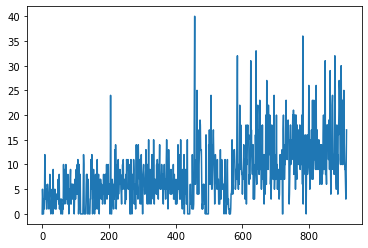

In [7]:
sales_df['sales_count'].plot()

In [26]:
def wpl(y_true, y_pred, tau):
    err = y_true - y_pred
    return np.mean(np.max((tau * err, (tau-1) * err), axis = 0))

class Series:
    def __init__(self, df, valcol):
        self.df = df
        self.columns = list(df.columns)
        self.valcol = valcol
        self.tseries = df[valcol]
        self.tseries_normed = (df[valcol] - df[valcol].mean())/df[valcol].std()
        self.tseries_log = np.log(2+df[valcol])
        self.length = len(df[valcol])
        self.description = df[valcol].describe()
        
    def plot_series(self, idx_range, **subplkwargs):
        plot_range = idx_range
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(tseries[plot_range])
        
    def plot_forecast(self, history, forecast, forecaste_conf_ints, back = 28, forward = 28, **subplkwargs):
        maxidx = history.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        plot_df = pd.DataFrame(history[-back:].append(forecast)).rename({0:'Sales'}, axis = 1)
        plot_df.loc[forecast.index, 'Type'] = 'Forecast'
        plot_df['Type'].fillna('Historic', inplace = True)
        plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'] = plot_df['Sales'], plot_df['Sales']
        plot_df.loc[forecast.index, 'forecast_conf_int_lower'] = forecast_conf_int['conf_int_lower'].values
        plot_df.loc[forecast.index, 'forecast_conf_int_upper'] = forecast_conf_int['conf_int_upper'].values
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(plot_df[plot_df['Type'] == 'Historic']['Sales'], color = 'black')
        ax.plot(plot_df[plot_df['Type'] == 'Forecast']['Sales'], color = 'green')
        ax.fill_between(plot_df.index, plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'], alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        
    def plot_acf(self, lags = [0,365], **subplkwargs):
        fig, ax = plt.subplots(**subplkwargs)
        autocorrelation_plot(sales[self.valcol], ax = ax)
        ax.set_xlim(lags)
        
    def model_arima(self, data, p=7, d=1, q=0):
        model = ARIMA(data, order=(p,d,q))
        model_fit = model.fit(disp=0)
        return(model, model_fit)
    
    def model_forecast(self, model_fit, forward = 28):
        forecast, forecast_stderr, forecast_conf_int = model_fit.forecast(forward)
        forecast = pd.Series(forecast)
        forecast_stderr = pd.Series(forecast_stderr)
        forecast_conf_int = pd.DataFrame(forecast_conf_int).rename({0:'conf_int_lower', 1:'conf_int_upper'}, axis = 1)
        maxidx = self.tseries.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        self.forecast = forecast
        self.forecast_stderr = forecast_stderr
        self.forecast_conf_int = forecast_conf_int
        return(forecast, forecast_stderr, forecast_conf_int)
    
    def fit_Prophet(self, ds, y, **params):
        model = Prophet(**params)
        self.df['y'] = self.df[y]
        self.df['ds'] = self.df[ds]
        model.fit(self.df)
        return(model)
    
    def forecast_Prophet(self, model, periods):
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        return(forecast)

        
    
    ###PROPHET FUNC
        
        
        
        


In [27]:
s = Series(sales_df[:-28], 'sales_count')

In [74]:
intervals = [0.995, 0.6]
quant_forecasts = { str(q): None for q in intervals}
prophparams = {'weekly_seasonality':True}
for k,v in quant_forecasts.items():
    prophparams.update({'interval_width':q})
    model = s.fit_Prophet(ds = 'ds', y = 'y', **prophparams)
    f = s.forecast_Prophet(model, periods = 365)
    ps = model.predictive_samples(f)
    quant_forecasts[k] = {'model':model,'forecast':f, 'pred_samples':ps}
    
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


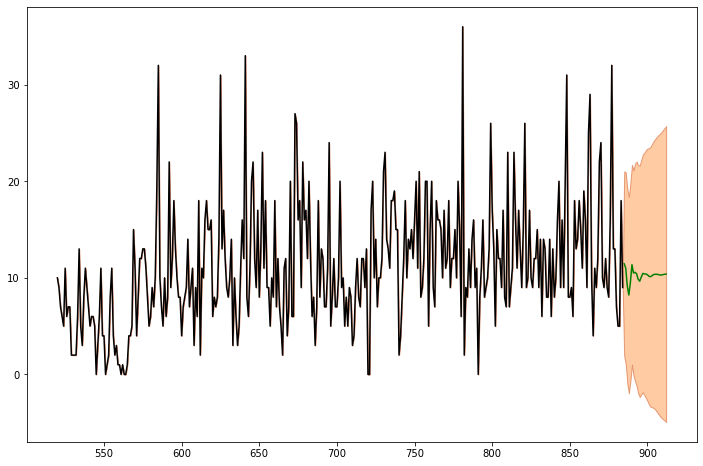

In [10]:
model, model_fit = s.model_arima(s.tseries)

forecast, forecast_stderr, forecast_conf_int = s.model_forecast(model_fit, forward = 28)

s.plot_forecast(s.tseries, forecast, forecast_conf_int, back = 365, forward = 28, **{'figsize': (12,8)})

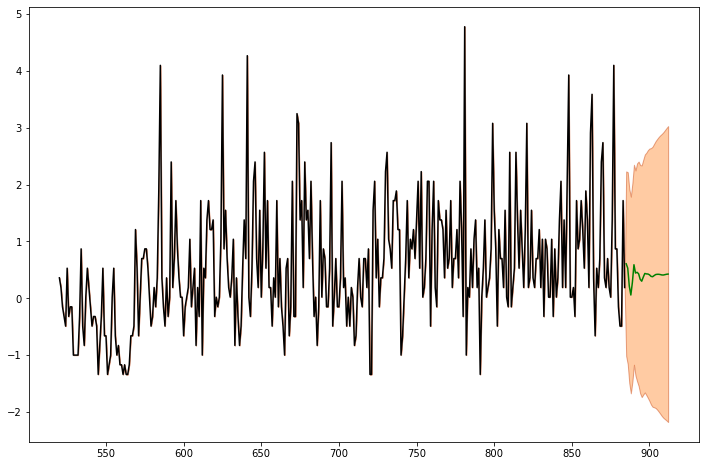

In [11]:
normed_model, normed_model_fit = s.model_arima(s.tseries_normed)

forecast, forecast_stderr, forecast_conf_int = s.model_forecast(normed_model_fit, forward = 28)

s.plot_forecast(s.tseries_normed, forecast, forecast_conf_int, back = 365, forward = 28, **{'figsize': (12,8)})

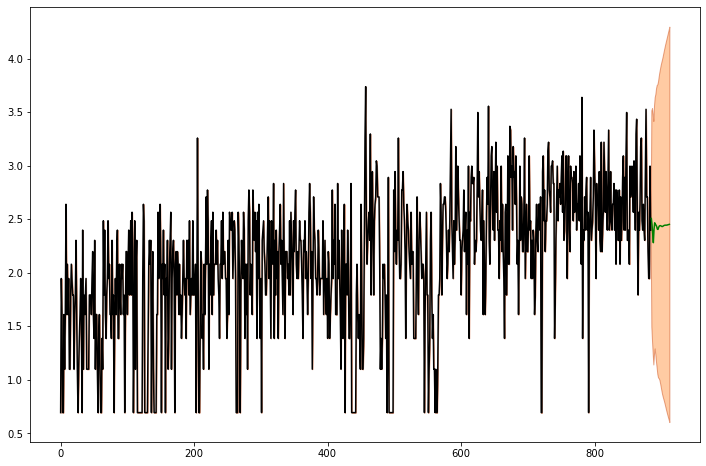

In [12]:
log_model, log_model_fit = s.model_arima(s.tseries_log)

forecast, forecast_stderr, forecast_conf_int = s.model_forecast(log_model_fit, forward = 28)

s.plot_forecast(s.tseries_log, forecast, forecast_conf_int, back = 1000, forward = 28, **{'figsize': (12,8)})

In [13]:
m = Prophet(daily_seasonality = True)
m.fit(sales_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

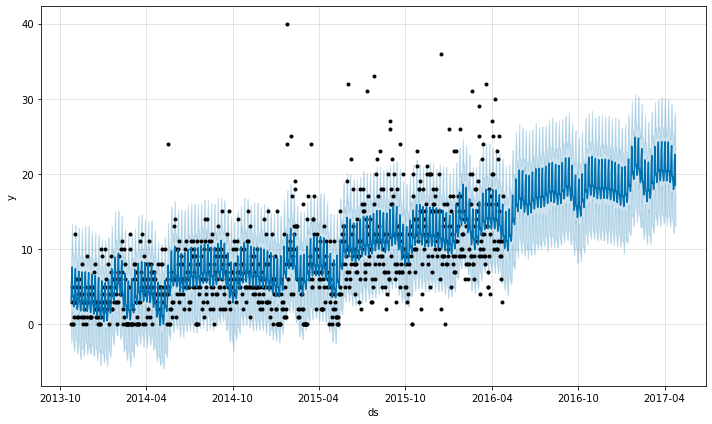

In [14]:
fig1 = m.plot(forecast)

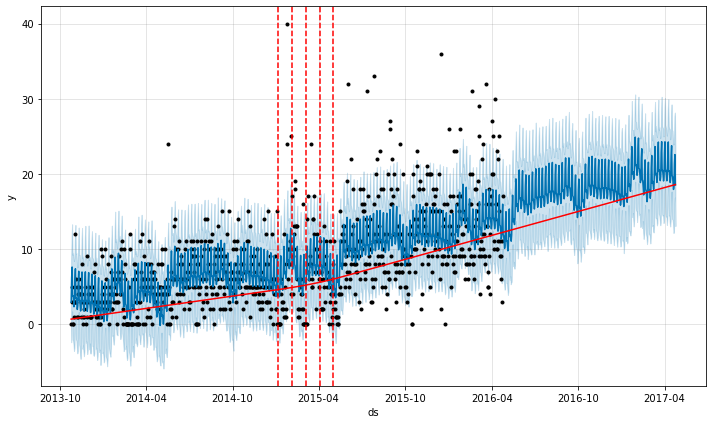

In [15]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

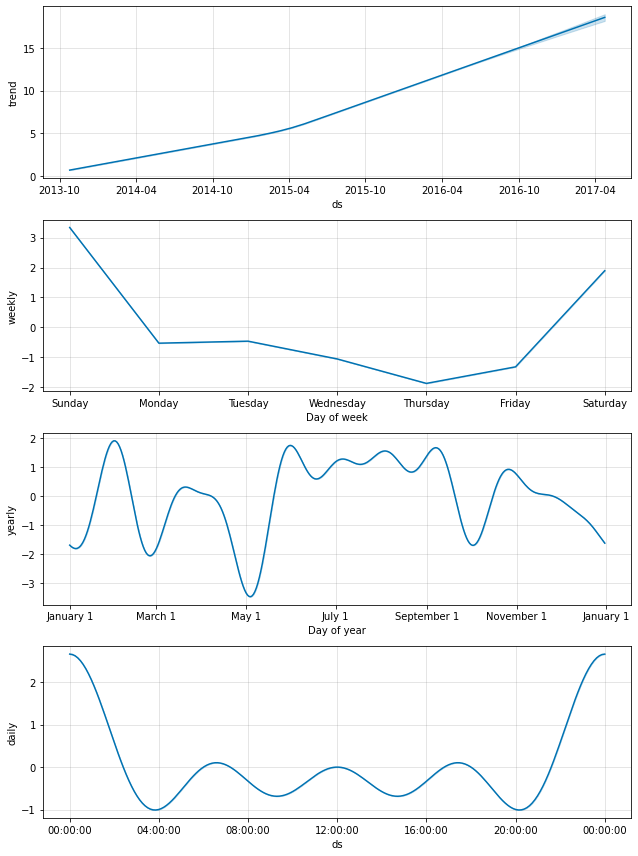

In [16]:
fig2 = m.plot_components(forecast)